# COGS 108 - Final Project - Analysis of Popular Music Through Billboard Mainstays

# Overview

*TODO*

# Names

- Caroline Sih
- Kelly Lo
- Chuyue Zhang
- Emma Leng
- Abigail Sigler

# Group Members IDs

- A14491488
- A15435725
- A14803791
- A######## TODO
- A14462479

# Research Question

*What are the common qualities of songs that make the Billboard Top 100 for more than one year, and do these qualities change over time?*

## Background and Prior Work

*Music has always been a major part of American society, and songs often reflect current events and cultural sentiment that is present in society at the time of their creation. Although most songs that experience popularity retain it only for a short period of time, some songs have stayed culturally relevant and popular over longer periods of time, and even decades.* 

*One of the most widely accepted measurements of musical popularity is the Billboard Top 100 chart, which releases a ranking of the best-performing songs in the United States each week. Each year, these consecutive rankings are combined to create a Top 100 chart for the entire year, which is a fair estimate of song popularity and their relevance in society for that period of time*

*Because music can be a response to current events and plays an important role in American society, the popularity of songs during a given year--and thus their presence on the Billboard Top 100--can be established to reflect their relevance in American culture. The common factors within these songs that persist in cultural relevance over time can be examined as an insight into American society.* 

References (include links):
- 1) https://data.world/kcmillersean/billboard-hot-100-1958-2017?fbclid=IwAR1P5o2E5IO19nJJSB5PjouSlIoIqRuPT0sDCZQrDqrj3XNm65LF-pRQNKA

- 2) https://spotipy.readthedocs.io/en/latest/

# Hypothesis


*We expect to see an increasing trend of globalization and diversity of gender and race of popular artists as time goes on, but a more explicit divide between incredibly popular, viral songs thanks to the advent of social media.*

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as pltcm
import seaborn as sns
import csv
import os
from math import pi

# Configure libraries
sns.set()

# Round decimals when displaying DataFrames
pd.set_option('precision', 4)

In [2]:
# Setup Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Get authorization key to use Spotify API from developer account
client_credentials_manager = SpotifyClientCredentials('84b5738225894c76aecf0578c6ff2862', '89d0aeb4ee7c4841b5800cd068ee3f69')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Data Cleaning

Describe your data cleaning steps here.

Here, we start by reading the csv files for the Billboard and Gender datasets. We also renamed the column 'artist' to 'Performer' for the Gender dataset for readability.

In [3]:
# load Billboard dataset
billboardWeekly = pd.read_csv('billboardHotWeekly.csv')
# load Gender dataset and rename the 'artist' column to 'Performer'
gender_data = pd.read_csv('singers_gender.csv', encoding = "ISO-8859-1")
gender_data.rename(columns ={'artist':'Performer'}, inplace=True)

We are now cleaning up the gender dataset and removing rows that may have missing values or unreadable symbols such as "?", "/", etc. We also noticed that this dataset had songwriters and guitarists which we did not need in our dataset so we ended up removing them. 

In [4]:
# clean up gender dataset
# Remove rows that have N/A data
gender_data.dropna()
# Remove rows that have weird symbol such as "?"
gender_data = gender_data[~gender_data['Performer'].str.contains('\?')]
gender_data = gender_data[~gender_data['Performer'].str.contains('\*')]

#Remove irrelevant data such as guitarists
gender_data = gender_data[~gender_data['category'].str.contains('guitarists')]
gender_data = gender_data[~gender_data['category'].str.contains('songwriters')]

Here, we created some helper functions that will help us clean the nationality of each artist since the dataset encodes that information with the job title and gender of that artist. 
The standardize_race() function will help us extract that information about the artist's nationality, removing characters like "\_" or "-" and what their occupation is. 
The standardize\_year() function helps us generalize the date of when the song charted Billboards by the decades as generalizing the data by decades will help us create cleaner and easier to read visualizations.

In [5]:
# helper functions
#Function to help clean up the category column
def standardize_race(race):
    # Make input all lowercase and drop all whitespace
    race = race.lower()
    race = race.strip()

    #Remove "singers", "male" , "female", "_"
    race = race.replace('female', '')
    race = race.replace('male', '')
    race = race.replace('singers', '')
    race = race.replace('_', '')
    race = race.replace('rappers', '')
    #Remove genre
    race = race.replace('pop', '')
    race = race.replace('rock', '')
    race = race.replace('jazz', '')
    race = race.replace('composers', '')
    race = race.replace('crooners', '')
    race = race.replace('country', '')
    race = race.replace('english', 'british')
    race = race.replace('scottish', 'british')
    race = race.replace('welsh', 'british')
    race = race.strip()
    race = race.replace('-', ' ')
    
    if len(race) > 1:
        output = race
    else:
        output = np.nan
        
    return output

#Collect year
def standardize_year(year):
    
    if "195" in year:
        out = 1950
    elif "196" in year:
        out = 1960
    elif "197" in year:
        out = 1970
    elif "198" in year:
        out = 1980
    elif "199" in year:
        out = 1990
    elif "200" in year:
        out = 2000
    elif "201" in year:
        out = 2010
    else:
        out = np.nan
    
    return out

In [6]:
#Apply the transformation and drop rows with missing information
gender_data['nationality'] = gender_data['category'].apply(standardize_race)
gender_data.dropna(subset=['nationality'], inplace=True)

Here, we merge the gender dataset board with the billboard dataset based on the "Performer" column. Then, we will further clean up this data by removing any rows with no values. After that, we apply the standarize_year() function to extract the year from the dataset. In addition, for some specific performers, they did not specify their nationality so we had to manually at it in.

In [7]:
# New df that will contain the two dfs
merge_bboard_gender_df = pd.merge(billboardWeekly, gender_data, on='Performer')
#Clean up the merged df and get rid of the unnamed columns
merge_bboard_gender_df = merge_bboard_gender_df.loc[:, ~merge_bboard_gender_df.columns.str.contains('^Unnamed')]

#Set a new year column and standardize the year to just decades
merge_bboard_gender_df[['Month', 'Day', 'Year']] = merge_bboard_gender_df.WeekID.str.split('/', expand=True)
#Drop the month and day
merge_bboard_gender_df = merge_bboard_gender_df.drop(['Month', 'Day'], axis=1)
merge_bboard_gender_df['Decade'] = merge_bboard_gender_df['Year'].apply(standardize_year)
merge_bboard_gender_df.loc[merge_bboard_gender_df.Performer == 'Sting', 'nationality'] = 'british'
merge_bboard_gender_df.loc[merge_bboard_gender_df.Performer == 'Jimmy Somerville', 'nationality'] = 'scottish'
merge_bboard_gender_df.loc[merge_bboard_gender_df.Performer == 'Rihanna', 'nationality'] = 'american'
merge_bboard_gender_df.loc[merge_bboard_gender_df.Performer == 'Eve', 'nationality'] = 'american'

In [8]:
#KELLY: This is for the top 30 across the whole of Billboard, if we don't need this data set, 
#remove this code as well!

# We will remove duplicates and count frequencies
new_df = billboardWeekly.groupby(['Performer']).size().reset_index()
new_df.rename(columns = {0: 'Frequency'}, inplace = True)
# sort the column in descending order
new_df = new_df.sort_values(by=['Frequency'], ascending = False)
# Test dropping all non-numeric rows
new_df = new_df[new_df['Frequency'].apply(lambda x: type(x) in [int, np.int64, float, np.float64])]
# Merge the two df's together
new_df_nat = pd.merge(new_df, gender_data, on='Performer')
new_df_nat = new_df_nat.drop('gender', axis=1)
new_df_nat
# manually set race for people
new_df_nat.loc[new_df_nat['Performer']=='Rihanna', 'nationality'] = 'american'

In [10]:
# create a new dictionary and store the max number of weeks on chart for each song/instance
dictSortIndex = {}
# number of songs that have been #1 on the list
peakList = []
for row in billboardWeekly.itertuples():
    # save to peak1 list
    if row.PeakPosition == 1:
        if not (row.SongID in peakList):
            peakList.append(row.SongID)
    # max weeks_on_chart
    if row.SongID in dictSortIndex.keys():
        if row.Instance in ((dictSortIndex[row.SongID]).keys()):
            if (dictSortIndex[row.SongID])[row.Instance] < row.WeeksOnChart:
                (dictSortIndex[row.SongID])[row.Instance] = row.WeeksOnChart
        else:
            (dictSortIndex[row.SongID])[row.Instance] = row.WeeksOnChart
    else:
        dictSortIndex[row.SongID] = {}
        (dictSortIndex[row.SongID])[row.Instance] = row.WeeksOnChart
        
# This is for songs that have reached the #1 on the chart
numOne = {}
for key in peakList:
    yr = billboardWeekly[billboardWeekly.SongID == key].WeekID.iloc[0].split('/')[2]
    if(yr in numOne.keys()):
        numOne[yr] += 1
    else:
        numOne[yr] = 1

In [11]:
# 1: number of songs with more than one instance on the charts
yearToInstance = {}
for key, value in dictSortIndex.items():
    if len(value.keys()) > 1:
        yr = billboardWeekly[billboardWeekly.SongID == key].WeekID.iloc[0].split('/')[2]
        if(yr in yearToInstance.keys()):
            yearToInstance[yr] += 1
        else:
            yearToInstance[yr] = 1

In [12]:
#cleaning the data for input into the spotify API
df = billboardWeekly[billboardWeekly['SongID'].isin(peakList)]
df = df.drop_duplicates(subset='SongID')
sp_df = df[['Song', 'Performer', 'WeekID'].copy()]
sp_df = sp_df.reset_index(drop='True')
sp_df['Song'] = sp_df['Song'].str.replace("'",'')
sp_df['Song'] = sp_df['Song'].str.replace('"','')
sp_df['Song'] = sp_df['Song'].str.replace(',','')
sp_df['Song'] = sp_df['Song'].str.replace('&','')
sp_df['Song'] = sp_df['Song'].str.split('/').str[0]
sp_df['Song'] = sp_df['Song'].str.split('-').str[0]
sp_df['Song'] =sp_df['Song'].str.replace(r"\(.*\)","")
sp_df['Performer'] = sp_df['Performer'].str.replace('&','')
sp_df['Performer'] = sp_df['Performer'].str.replace("Featuring",'')
sp_df['Performer'] = sp_df['Performer'].str.replace("With",'')
sp_df['Performer'] = sp_df['Performer'].str.replace("And",'')
sp_df['Performer'] = sp_df['Performer'].str.replace(r"\(.*\)","")

In [13]:
# add data to below sets
dance = []
energy = []
speech = []
acoustic = []
valence = []
tempo = []
for i in sp_df.index:
    artist = sp_df.loc[i,'Performer']
    track = sp_df.loc[i, 'Song']
    track_search = sp.search(q='artist:' + artist + ' track:' + track, limit=1, type='track')
    if track_search['tracks']['total'] == 0:
        track_id = 'none'
    else:
        track_id = track_search['tracks']['items'][0]['id']
    atts = sp.audio_features(track_id)
    if atts == [None]:
        dance.append('NaN')
        energy.append('NaN')
        speech.append('Nan')
        acoustic.append('NaN')
        valence.append('NaN')
        tempo.append('NaN')
    else:
        dance.append(atts[0]['danceability'])
        energy.append(atts[0]['energy'])
        speech.append(atts[0]['speechiness'])
        acoustic.append(atts[0]['acousticness'])
        valence.append(atts[0]['valence'])
        tempo.append(atts[0]['tempo'])

# set the dataframe with corresponding data
sp_df['danceability'] = dance
sp_df['energy'] = energy
sp_df['speechiness'] = speech
sp_df['acousticness'] = acoustic
sp_df['valence'] = valence
sp_df['tempo'] = tempo
sp_df = sp_df[sp_df['danceability'] != 'NaN' ]
sp_df['WeekID'] = sp_df['WeekID'].str[-4:-1]

In [14]:
# music by decades
fifties = sp_df.loc[sp_df['WeekID'] == '195']
sixties = sp_df.loc[sp_df['WeekID'] == '196']
seventies = sp_df.loc[sp_df['WeekID'] == '197']
eighties = sp_df.loc[sp_df['WeekID'] == '198']
nineties = sp_df.loc[sp_df['WeekID'] == '199']
oughts = sp_df.loc[sp_df['WeekID'] == '200']
tens = sp_df.loc[sp_df['WeekID'] == '201']

dance50 = fifties['danceability'].mean()
energy50 = fifties['energy'].mean()
speech50 = fifties['speechiness'].mean()
acoustic50 = fifties['acousticness'].mean()
valence50 = fifties['valence'].mean()
tempo50 = fifties['tempo'].mean()

In [15]:
# load gender dataset
dfGender = pd.read_csv('singers_gender.csv', encoding= 'latin1') 

In [16]:
# drop null value entries
dfGender= dfGender.dropna(subset= ['gender'])

# renaming artists column as performer
dfGender=dfGender.rename(columns= {'artist':'Perfomer'})

# drop unneccesary column
dfGender=dfGender.drop(['category'], axis=1)

In [17]:
# TODO delete this if not use emma's second merge df
simpBillboardDF = billboardWeekly.drop(['SongID', 'PreviousWeekPosition', 'PeakPosition', 'Week Position', 'Instance', 'url'], axis=1)

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

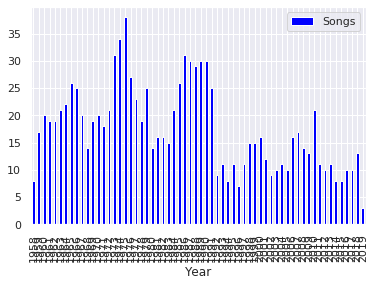

In [18]:
# TODO need title
# histogram to map year against number of songs reaching number 1
data = {'Year': list(numOne.keys()), 'Songs': list(numOne.values())}
numOneDF = pd.DataFrame(data)
numOneDF = numOneDF.sort_values("Year")
numOneDF.plot(kind='bar', x= 'Year', y='Songs', color='blue')
plt.savefig('YEARSx#SONGSREACHINGNUM1')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


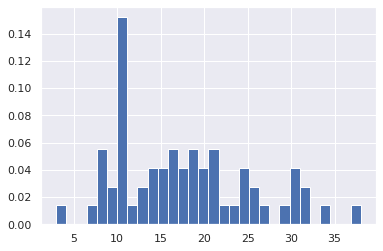

38

In [19]:
#TODO need more explanation on this
#TODO need title
x = numOneDF['Songs']
plt.hist(x, normed=True, bins=30)
plt.savefig('YEARSx#SONGSREACHINGNUM1HIST')
plt.show()
x.max()

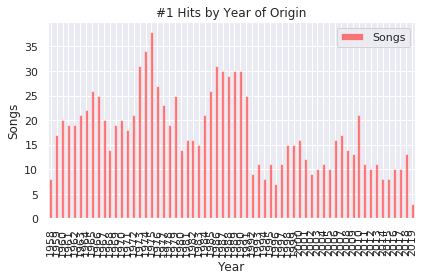

In [20]:
# TODO need more explanation on this
numOneDF.plot(kind='bar', x= 'Year', y='Songs', color='red', alpha=0.5)
plt.savefig('YEARSx#SONGSREACHINGNUM1')
plt.ylabel('Songs')
plt.title('#1 Hits by Year of Origin')
plt.tight_layout()
plt.show()

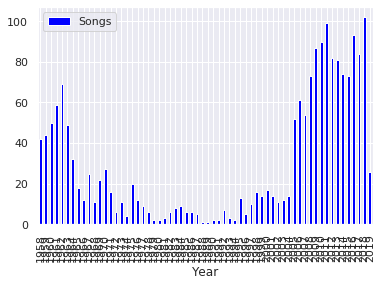

In [21]:
data = {'Year': list(yearToInstance.keys()), 'Songs': list(yearToInstance.values())}
yearInstanceDF = pd.DataFrame(data)
yearInstanceDF = yearInstanceDF.sort_values("Year")
yearInstanceDF.plot(kind='bar', x= 'Year', y='Songs', color='blue')
plt.savefig('YEARSxMUL_INSTANCES')
plt.show()

The above data illustrates the mapping of each year (on the x axis) to the number of songs with more than one instance of appearing on the Billboard Weekly Top 100. Songs that are extremely popular by this metric are therefore becoming increasingly more common as time goes on, as demonstrated by the sharp rise since the mid-1970s (in which appeared very few songs with more than one instance).

Another factor at play here is the resurgence of many songs, as mainstream fascination with past culture has seen a heighted presence in recent years. For instance, popular songs by ABBA and The Beatles have had resurgences in recent years, demonstrating the enduring nature of music and artists who have remained relevant to the public eye.

An additional factor in recurring songs is that holiday songs, such as Christmas or Halloween songs, have a sharp seasonal ebb and flow that would lend themselves toward higher representation on these lists. Because they regain spots on the list seasonally, they would be more highly represented here than a song that is extremely popular but fades in popularity eventually without resurgence.

Factors to explore in the future include the high density of songs that have seen resurgences peaking in the early 1960s.

In [22]:
# TODO delete this later
# below begins Kelly's code

Now let's take a look at the nationality distribution to the Billboard top 100 songs.



We split up the nationality distribution into decades and split them into three big timelines: 1950s-1970s, 1980s-1990s, and 2000s-2010s.

The below pie chart describes the nationalities of all the artists on the Billboard Top 100 for the decades 1950s-1960s.

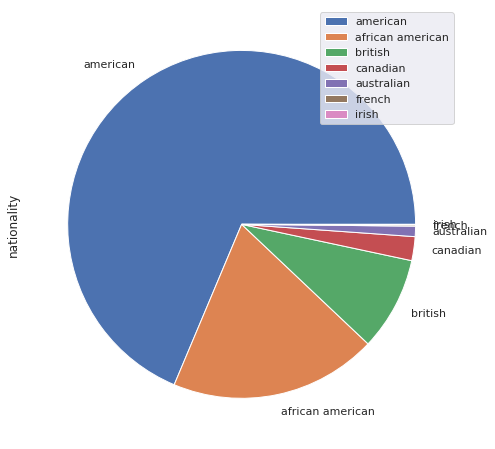

In [23]:
# TODO some explanation as introduction to this code
fifty_seventy_dec = merge_bboard_gender_df[(merge_bboard_gender_df.Decade == 1950)|(merge_bboard_gender_df.Decade == 1960)|(merge_bboard_gender_df.Decade == 1970)]
fsd_vals = fifty_seventy_dec['nationality'].value_counts().to_frame()
fsd_cat = fifty_seventy_dec['nationality'].value_counts().index.tolist()
fsd_vals.plot.pie(y='nationality', figsize=(8,8))

Below is the pie chart for the decades 1980s to 1990s.

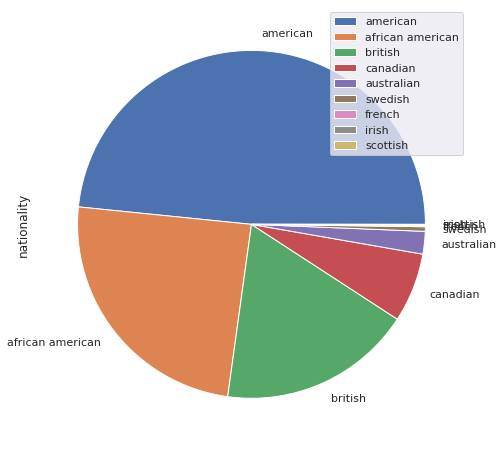

In [24]:
# TODO descr
eighty_ninety_dec = merge_bboard_gender_df[(merge_bboard_gender_df.Decade == 1980)|(merge_bboard_gender_df.Decade == 1990)]
end_vals = eighty_ninety_dec['nationality'].value_counts().to_frame()
end_cat = eighty_ninety_dec['nationality'].value_counts().index.tolist()
end_vals.plot.pie(y='nationality', figsize=(8,8))

Interestly, we can notice that there was a surge of African American and British artists during the 1980s-1990s. This is most likely due to the fact that in the beginning of 1980s, the trend of disco started to fall and music genres like rock gained more and more attention across the United States. This rise of rock help contribute to the rise of European artists on the Billboard. For example, some of the most popular artists of the 1980s decade included Queen, Def Leppard, and The Rolling Stones, which are all British/English rock bands. During these two decades, some of these British acts managed to outsell American artists, giving rise to the “Second British Invasion”. Some songs that stayed prominent on the chart included “Another One Bites the Dust” by Queen and “Love Bites” by Def Leppard. “Another One Bites the Dust” peaked to #1 for three weeks and stayed on the Billboard chart for 31 weeks in the 1980s. “Love Bites” peaked to #1 for one week and stayed on the Billboard charts for 23 weeks in the 1980s. 

Cultural aspects from the African American communities had a strong influence on the popular music in the 1980s which carried all way through into the 1990s. Some of these cultural aspects included hip-hop, rap music, and break dancing. These aspects influenced the pop and R&B music which rose up into the Billboard top charts. The rise of these genres also brought in the dancibility and use of the rhythm of the body in the songs. Very prominent artists that dominated the charts included Michael Jackson, Prince, Whitney Houston, and Lionel Richie. These artists were prominent figures of the music industry in the United States and they stayed significant all the way into the 1990s. For example, Michael Jackson’s Thriller album released in 1982 became the best-selling album of all time selling 25 million copies during that decade. His later album, Bad, released in 1987, became the first album in history to have five number-one singles on Billboard Hot 100. With the rise of a new wave of popular music such as hip hop, rock, and pop, this brought in new artists of different nationalities that populated the Billboard charts. 


To generalize, above three pie charts are visualizations of the nationalities of the performers of the songs that have reached the Billboard Top 100 for the three sections of decades. It is separated into three different intervals of decades where the first visualization is 1950s-1970s, second is 1980s-1990s, and third is 2000s-2010s. As we can see, what stayed the same through all these decades is that a majority of the artists that were on the Billboard Top 100 were American unsurprisingly. Since the Billboard charts ranks songs according to sales, streams or airplay, and from the main song charts in the United States, it is no surprise that throughout the decades, American artists stayed as a strong prominent portion of the Billboard charts.

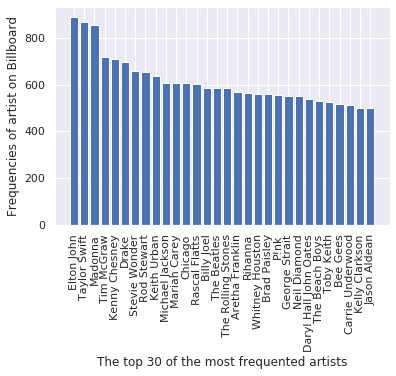

In [25]:
#Get the top 30 of the top freqs
top_freqs = new_df.head(30)
#Frequency represents the number of times that artist had a song 
#in the Billboard top 100.
t_f_height = top_freqs['Frequency'].tolist()
t_f_bars = top_freqs['Performer'].tolist()
t_f_y_pos = np.arange(len(t_f_bars))
plt.bar(t_f_y_pos, t_f_height)
plt.xticks(t_f_y_pos, t_f_bars, rotation='vertical')
plt.xlabel("The top 30 of the most frequented artists")
plt.ylabel("Frequencies of artist on Billboard")
plt.show()

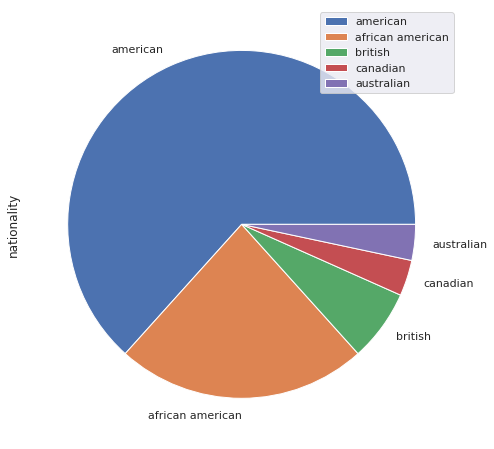

In [26]:
# TODO descr
top_freq_nat = new_df_nat.head(30)
top_nat = top_freq_nat['nationality'].value_counts().to_frame()
top_nat_cat = top_freq_nat['nationality'].value_counts().index.tolist()

top_nat.plot.pie(y='nationality', figsize=(8,8))

In [27]:
# end of kelly's code
# TODO need some portion summary

In [28]:
# begins abby's code
# TODO need summary

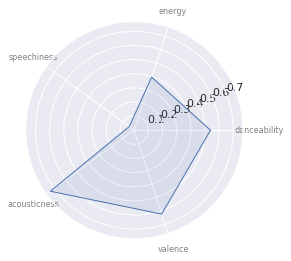

In [29]:
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
dance50 = fifties['danceability'].mean()
energy50 = fifties['energy'].mean()
speech50 = fifties['speechiness'].mean()
acoustic50 = fifties['acousticness'].mean()
valence50 = fifties['valence'].mean()
categories = ['danceability', 'energy', 'speechiness', 'acousticness', 'valence']
values= [dance50, energy50, speech50, acoustic50, valence50]
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(5) * 2 * pi for n in range(5)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)

 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

In [30]:
# begin emma's code

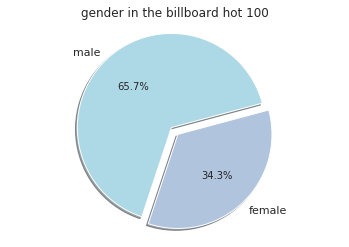

In [31]:
# TODO need explanation
gender = [15236,7941] # TODO can we hardcode this?
my_labels = 'male','female',
my_colors = ['lightblue','lightsteelblue']
my_explode = (0.1, 0)
plt.pie(gender, labels=my_labels, autopct='%1.1f%%', startangle=15, shadow = True, colors=my_colors, explode=my_explode)
plt.title('gender in the billboard hot 100')
plt.axis('equal')
plt.show()

In [35]:
# merge two datasets

#dfGenMus = pd.merge(dfGender,(simpBillboardDF[['Performer', 'WeekID']]), on='Performer')
#dfGenMus.head()
#TODO can't compile

In [36]:
#ax = df.plot.bar(rot=0)

# Ethics & Privacy

Because the Billboard Top 100 represents the songs that are most popular based on play time and sales within the United States, there may be biases within the data that reflect biases of western society at each point. We also recognize that we are approaching this project from the standpoint of college students, who do not represent the whole population of music listeners. As we continue in this project, we will continue to consider and take note of any additional ethical considerations that crop up.

# Conclusion & Discussion

*Fill in your discussion information here*